## Importing libray

In [10]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

from bokeh.models import ColumnDataSource, Plot, Range1d, TapTool, CustomJS, LinearColorMapper, ColorBar, NumeralTickFormatter, HoverTool, Title, Label
from bokeh.models.glyphs import Text
from bokeh.palettes import brewer
from bokeh.colors import Color
from bokeh.colors import RGB
from bokeh.colors import named
from bokeh.io import show, output_file, reset_output
from bokeh.plotting import figure
from bokeh.embed import file_html

## Loading restriction data

In [11]:
df = pd.read_csv('covidrestrictions.csv')
df.head()

,Country,A3Code,X,Y,Status,Description,Vaccination
0,Afghanistan,AFG,66.026881,33.831602,Open with restrictions,Most visitors from the United States need to p...,2.08% of population has been vaccinated
1,Albania,ALB,20.066643,41.138926,Open with restrictions,Unvaccinated visitors from the United States c...,34.10% of population has been vaccinated\r
2,Algeria,DZA,2.678028,28.157361,Open with restrictions,Most visitors from the United States will not ...,13.49% of population has been vaccinated
3,American Samoa,ASM,-170.718060,-14.300686,Closed,NaN,NaN
4,Angola,AGO,17.577532,-12.337524,Open with restrictions,Most visitors from the United States need to p...,11.16% of population has been vaccinated


## Loading shapefile 

In [12]:
## Call in the Shapefile 
shapefile = 'ne_10m_admin_0_countries.shp'
gdf = gpd.read_file(shapefile)[['ADMIN','geometry']]
gdf.columns = ['Country', 'geometry']
gdf.head()

,Country,geometry
0,Indonesia,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4..."
1,Malaysia,"MULTIPOLYGON (((117.70361 4.16341, 117.69711 4..."
2,Chile,"MULTIPOLYGON (((-69.51009 -17.50659, -69.50611..."
3,Bolivia,"POLYGON ((-69.51009 -17.50659, -69.51009 -17.5..."
4,Peru,"MULTIPOLYGON (((-69.51009 -17.50659, -69.63832..."


## Merging dataframe

In [13]:
## Merge dataframe with shapefile
merged_df = gdf.merge(df, how='left',left_on='Country', right_on='Country')
merged_df.drop(columns=['X','Y'], inplace=True)

merged_df = merged_df[merged_df.geometry.notnull()]
merged_df = merged_df.explode()

merged_df.head(10)

Country A3Code                  Status  \
0 0  Indonesia    IDN  Open with restrictions   
  1  Indonesia    IDN  Open with restrictions   
  2  Indonesia    IDN  Open with restrictions   
  3  Indonesia    IDN  Open with restrictions   
  4  Indonesia    IDN  Open with restrictions   
  5  Indonesia    IDN  Open with restrictions   
  6  Indonesia    IDN  Open with restrictions   
  7  Indonesia    IDN  Open with restrictions   
  8  Indonesia    IDN  Open with restrictions   
  9  Indonesia    IDN  Open with restrictions   

                                           Description  \
0 0  Unvaccinated visitors from the United States w...   
  1  Unvaccinated visitors from the United States w...   
  2  Unvaccinated visitors from the United States w...   
  3  Unvaccinated visitors from the United States w...   
  4  Unvaccinated visitors from the United States w...   
  5  Unvaccinated visitors from the United States w...   
  6  Unvaccinated visitors from the United States w...   
  7  Unvaccinated visitors from the United States w...   
  8  Unvaccinated visitors from the United States w...   
  9  Unvaccinated visitors from the United States w...   

                                  Vaccination  \
0 0  39.73% of population has been vaccinated   
  1  39.73% of population has been vaccinated   
  2  39.73% of population has been vaccinated   
  3  39.73% of population has been vaccinated   
  4  39.73% of population has been vaccinated   
  5  39.73% of population has been vaccinated   
  6  39.73% of population has been vaccinated   
  7  39.73% of population has been vaccinated   
  8  39.73% of population has been vaccinated   
  9  39.73% of population has been vaccinated   

                                              geometry  
0 0  POLYGON ((117.70361 4.16341, 117.70361 4.16341...  
  1  POLYGON ((124.45053 -9.18019, 124.46583 -9.179...  
  2  POLYGON ((117.56715 4.15965, 117.56707 4.15961...  
  3  POLYGON ((140.97446 -2.60052, 140.97447 -2.631...  
  4  POLYGON ((113.39519 -8.44704, 113.40610 -8.453...  
  5  POLYGON ((123.14625 -8.42596, 123.16977 -8.431...  
  6  POLYGON ((128.23121 -8.25123, 128.23764 -8.264...  
  7  POLYGON ((129.02963 -8.20680, 129.03614 -8.220...  
  8  POLYGON ((127.74187 -8.15895, 127.76059 -8.173...  
  9  POLYGON ((117.66432 -8.14813, 117.67311 -8.154...

<AxesSubplot:>

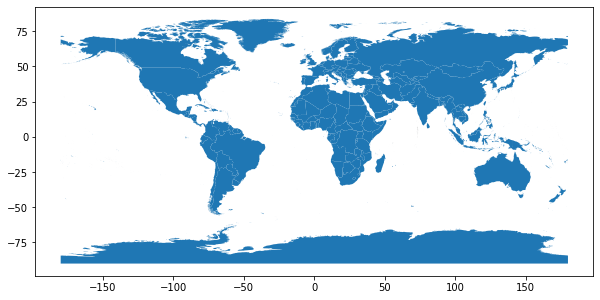

In [14]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
merged_df.plot(ax=ax)

## Defining and applying color functions

In [15]:
def color_func(single_value):
    color=None
    if single_value=='Open with restrictions':
        color = named.orange
    elif single_value=='Closed':
        color = named.red
    elif single_value=='Open':
        color = named.green
    else:
        color = named.gray
    return color
    

In [16]:
status_all = merged_df['Status'].unique()
merged_df['Color'] = merged_df.apply(lambda x: color_func(x['Status']), axis=1)

## Interactive map preparation

In [17]:
result = merged_df.copy()
reset_output()
output_file("interactive_map.html")
x, y = [], []


[(x.append(list(polygon.exterior.coords.xy[0])), y.append(list(polygon.exterior.coords.xy[1]))) for polygon in result['geometry']]


TOOLS="hover,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"


data_main = ColumnDataSource(dict(x = x, y = y,
                                  country = result['Country'],
                                  status = result['Status'],
                                  description = result['Description'],
                                  vaccination = result['Vaccination'],
                                  color = result['Color']
                                 ))


main_plot = figure(title = "Interactive Map of Travel Restrictions" ,
                   tools='tap,reset,pan,wheel_zoom,zoom_in,zoom_out,box_zoom', match_aspect=True,
                   plot_width = 1200, aspect_scale=2,
                    x_range=(np.min(np.min(x)), np.max(np.max(x))), 
                   y_range=(np.min(np.min(y)), np.max(np.max(y))), output_backend="webgl")
                  #toolbar=TOOLS)

#tile_provider = get_provider(Vendors.STAMEN_TERRAIN_RETINA)
#tile_provider = get_provider(Vendors.CARTODBPOSITRON_RETINA)
#main_plot.add_tile(tile_provider)

regions = main_plot.patches('x', 'y', source = data_main,
                    fill_color = {'field' : 'color'},
                    legend_field ='status',
                    line_color = 'white', line_width = 0.25, fill_alpha = 0.8)
                            #nonselection_fill_color=None,)





hover = HoverTool(renderers=[regions],tooltips=[
        ("Country", "@country"), ("Status","@status"), 
    ("Description","@description"), ('Vaccination', "@vaccination")]) # only for circles

main_plot.add_tools(hover)
#main_plot.add_layout(color_bar, 'right')
main_plot.title.text_font_size='20pt'
main_plot.legend.location = "center_left"
#main_plot.legend.click_policy="hide"



#
show(main_plot)

C:\Users\Frank\anaconda3\envs\pyvizenv\lib\site-packages\numpy\core\fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
